In [1]:
%load_ext autoreload

In [2]:
%run ./common_init.ipynb

Setup logging to file: out.log
Figure output directory saved in figure_output at /home/datarian/OneDrive/unine/Master_Thesis/ma-thesis-report/figures


In [3]:
%autoreload 2
import numpy as np
from sklearn.impute import SimpleImputer

# Load custom code
import kdd98.data_handler as dh
from kdd98.config import Config

from fancyimpute import KNN, IterativeImputer, BiScaler

Using TensorFlow backend.


In [4]:
# Where to save the figures
IMAGES_PATH = pathlib.Path(figure_output/'preprocessing')

pathlib.Path(IMAGES_PATH).mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = pathlib.Path(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
data_provider = dh.KDD98DataProvider("cup98LRN.txt")

In [11]:
preprocessed = data_provider.preprocessed_data

In [12]:
numeric = data_provider.numeric_data

# Imputation

A high-level look at missing data: White represents missing values. To the right, we can see the exampple with the least and most non-NA values.

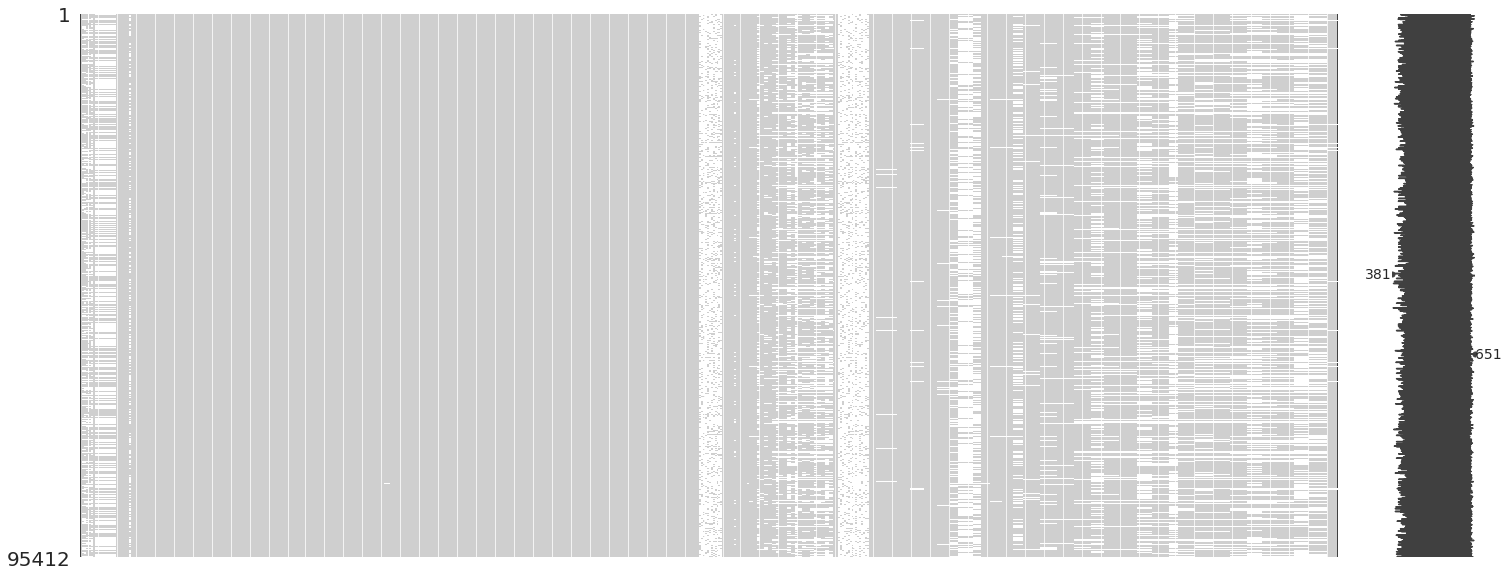

In [13]:
import missingno as msno
msno.matrix(numeric)
save_fig("missing_matrix", tight_layout=False)

## Categoricals

Nominal features cannot be imputed by sophisticated imputation methods. The nominal features are therefore first imputed using the mode of each feature.

In [14]:
categoricals = preprocessed.select_dtypes(include="category")
categorical_features = categoricals.columns.values.tolist()

In [15]:
imputed_categoricals = categoricals.fillna(categoricals.mode().iloc[0])

In [16]:
for c in imputed_categoricals[[c for c in imputed_categoricals.columns if imputed_categoricals[c].cat.categories.dtype == 'object']]:
    print("{} has {} levels:\n{}".format(c,len(categoricals[c].cat.categories),categoricals[c].cat.categories))
    print("Number of missing values left: {}".format(imputed_categoricals[c].isna().sum()))

OSOURCE has 895 levels:
Index(['AAA', 'AAD', 'AAM', 'ABC', 'ABD', 'ABP', 'ABW', 'ACB', 'ACC', 'ACD',
       ...
       'WTW', 'WWC', 'WWF', 'WWM', 'YAL', 'YAN', 'YKA', 'YKD', 'YNF', 'ZOY'],
      dtype='object', length=895)
Number of missing values left: 0
TCODE has 55 levels:
Index(['0', '1', '100', '1002', '116', '12', '13', '13002', '134', '136', '14',
       '14002', '17', '18', '18002', '2', '202', '21', '22', '22002', '228',
       '23', '24', '24002', '25', '27', '28', '28028', '3', '30', '36', '38',
       '39002', '4', '40', '4002', '4004', '42', '44', '45', '47', '50',
       '58002', '6', '61', '6400', '7', '72', '72002', '76', '9', '93', '94',
       '96', '980'],
      dtype='object')
Number of missing values left: 0
STATE has 57 levels:
Index(['AA', 'AE', 'AK', 'AL', 'AP', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC',
       'DE', 'FL', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA',
       'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH',
  

In [17]:
preprocessed[imputed_categoricals.columns] = imputed_categoricals

## missingpy
https://github.com/epsilon-machine/missingpy

Olga Troyanskaya, Michael Cantor, Gavin Sherlock, Pat Brown, Trevor Hastie, Robert Tibshirani, David Botstein and Russ B. Altman, Missing value estimation methods for DNA microarrays, BIOINFORMATICS Vol. 17 no. 6, 2001 Pages 520-525

This step requires that we first drop features with more than 80% missing values for the KNNImputer to work.

Best results with k=3: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4959387/

The challenge with KNN imputation it that the algorithm first builds a `n` x `n` distance matrix. 
For the dataset at hand, this means 95412^2, which is an incredible amount of memory (73 GB, to be precise).

In [18]:
bits = 95412**2*64
bytes = bits/8
gb = bytes * 1e-9
gb

72.827597952

An approach is to split the data into chunks whose distance matrix will fit into memory. We could then impute the chunks individually and recombine the data afterwards.

However, this has a drawback: The best neighbours are no longer guaranteed to be in the data available in a given chunk.

In [19]:
for i in range(2,6):
    p = 1/i
    p_1 = p 
    p_2 = p**2
    p_3 = p**3
    print("Probability with {} chunks to have 1, 2, 3 best neighbours in it: {}, {}, {}"
          .format(i, p_1, p_2, p_3))

Probability with 2 chunks to have 1, 2, 3 best neighbours in it: 0.5, 0.25, 0.125
Probability with 3 chunks to have 1, 2, 3 best neighbours in it: 0.3333333333333333, 0.1111111111111111, 0.03703703703703703
Probability with 4 chunks to have 1, 2, 3 best neighbours in it: 0.25, 0.0625, 0.015625
Probability with 5 chunks to have 1, 2, 3 best neighbours in it: 0.2, 0.04000000000000001, 0.008000000000000002


In [20]:
import psutil
dict(psutil.virtual_memory()._asdict())

{'total': 29503549440,
 'available': 21518749696,
 'percent': 27.1,
 'used': 7511527424,
 'free': 16564027392,
 'active': 9681809408,
 'inactive': 1625817088,
 'buffers': 900321280,
 'cached': 4527673344,
 'shared': 17772544,
 'slab': 874962944}

In [21]:
psutil.virtual_memory()._asdict()['available']

21518749696

In [22]:
n_chunks = np.floor_divide(bytes, psutil.virtual_memory()._asdict()['available'])
n_ex_per_chunk = int(np.floor_divide(numeric.shape[0], n_chunks)) #chunk row size
n_ex_per_chunk

31804

In [23]:
chunks = [numeric[i:i+n_ex_per_chunk] for i in range(0,numeric.shape[0],n_ex_per_chunk)]

In [24]:
[chunk.shape for chunk in chunks]

[(31804, 662), (31804, 662), (31804, 662)]

In [35]:
from missingpy import KNNImputer
processed = list()
for chunk in chunks:
    log("Started KNN-imputing new chunk...")
    imputer = KNN(k=3, normalizer=BiScaler())
    # imputer = KNNImputer(n_neighbors=3, weights="distance")
    processed.append(imputer.fit_transform(chunk.values))

2019-03-20 14:08:05.445171 Started KNN-imputing new chunk...
[BiScaler] Initial log residual value = 19.902331
[BiScaler] Iter 1: log residual = 5.533235, log improvement ratio=14.369096
[BiScaler] Iter 2: log residual = 4.627643, log improvement ratio=0.905592
[BiScaler] Iter 3: log residual = 4.148407, log improvement ratio=0.479236
[BiScaler] Iter 4: log residual = 3.796865, log improvement ratio=0.351542
[BiScaler] Iter 5: log residual = 3.505013, log improvement ratio=0.291851
[BiScaler] Iter 6: log residual = 3.250774, log improvement ratio=0.254239
[BiScaler] Iter 7: log residual = 3.023901, log improvement ratio=0.226873
[BiScaler] Iter 8: log residual = 2.818359, log improvement ratio=0.205542
[BiScaler] Iter 9: log residual = 2.630101, log improvement ratio=0.188257
[BiScaler] Iter 10: log residual = 2.456197, log improvement ratio=0.173904
[BiScaler] Iter 11: log residual = 2.294421, log improvement ratio=0.161776
[BiScaler] Iter 12: log residual = 2.143028, log improvement 

Imputing row 701/31804 with 52 missing, elapsed time: 4961.112
Imputing row 801/31804 with 56 missing, elapsed time: 4963.611
Imputing row 901/31804 with 52 missing, elapsed time: 4966.179
Imputing row 1001/31804 with 86 missing, elapsed time: 4968.759
Imputing row 1101/31804 with 87 missing, elapsed time: 4971.245
Imputing row 1201/31804 with 123 missing, elapsed time: 4973.836
Imputing row 1301/31804 with 172 missing, elapsed time: 4976.412
Imputing row 1401/31804 with 62 missing, elapsed time: 4978.982
Imputing row 1501/31804 with 121 missing, elapsed time: 4981.304
Imputing row 1601/31804 with 67 missing, elapsed time: 4984.081
Imputing row 1701/31804 with 83 missing, elapsed time: 4986.787
Imputing row 1801/31804 with 84 missing, elapsed time: 4989.250
Imputing row 1901/31804 with 62 missing, elapsed time: 4991.557
Imputing row 2001/31804 with 32 missing, elapsed time: 4994.062
Imputing row 2101/31804 with 78 missing, elapsed time: 4996.636
Imputing row 2201/31804 with 73 missing,

Imputing row 13401/31804 with 63 missing, elapsed time: 5289.167
Imputing row 13501/31804 with 150 missing, elapsed time: 5291.742
Imputing row 13601/31804 with 34 missing, elapsed time: 5294.518
Imputing row 13701/31804 with 124 missing, elapsed time: 5297.072
Imputing row 13801/31804 with 52 missing, elapsed time: 5299.596
Imputing row 13901/31804 with 225 missing, elapsed time: 5302.203
Imputing row 14001/31804 with 65 missing, elapsed time: 5304.818
Imputing row 14101/31804 with 57 missing, elapsed time: 5307.293
Imputing row 14201/31804 with 30 missing, elapsed time: 5309.796
Imputing row 14301/31804 with 36 missing, elapsed time: 5312.382
Imputing row 14401/31804 with 76 missing, elapsed time: 5315.115
Imputing row 14501/31804 with 202 missing, elapsed time: 5317.839
Imputing row 14601/31804 with 225 missing, elapsed time: 5320.208
Imputing row 14701/31804 with 77 missing, elapsed time: 5323.007
Imputing row 14801/31804 with 199 missing, elapsed time: 5325.611
Imputing row 14901/

Imputing row 26001/31804 with 78 missing, elapsed time: 5615.556
Imputing row 26101/31804 with 62 missing, elapsed time: 5618.220
Imputing row 26201/31804 with 159 missing, elapsed time: 5620.874
Imputing row 26301/31804 with 72 missing, elapsed time: 5623.402
Imputing row 26401/31804 with 159 missing, elapsed time: 5626.116
Imputing row 26501/31804 with 103 missing, elapsed time: 5628.823
Imputing row 26601/31804 with 122 missing, elapsed time: 5631.187
Imputing row 26701/31804 with 129 missing, elapsed time: 5633.588
Imputing row 26801/31804 with 77 missing, elapsed time: 5636.395
Imputing row 26901/31804 with 75 missing, elapsed time: 5638.938
Imputing row 27001/31804 with 72 missing, elapsed time: 5641.414
Imputing row 27101/31804 with 42 missing, elapsed time: 5643.969
Imputing row 27201/31804 with 225 missing, elapsed time: 5646.586
Imputing row 27301/31804 with 45 missing, elapsed time: 5649.220
Imputing row 27401/31804 with 160 missing, elapsed time: 5651.659
Imputing row 27501

[BiScaler] Iter 57: log residual = -1.708382, log improvement ratio=0.056933
[BiScaler] Iter 58: log residual = -1.764797, log improvement ratio=0.056414
[BiScaler] Iter 59: log residual = -1.820711, log improvement ratio=0.055915
[BiScaler] Iter 60: log residual = -1.876144, log improvement ratio=0.055433
[BiScaler] Iter 61: log residual = -1.931113, log improvement ratio=0.054969
[BiScaler] Iter 62: log residual = -1.985634, log improvement ratio=0.054521
[BiScaler] Iter 63: log residual = -2.039722, log improvement ratio=0.054089
[BiScaler] Iter 64: log residual = -2.093394, log improvement ratio=0.053671
[BiScaler] Iter 65: log residual = -2.146662, log improvement ratio=0.053268
[BiScaler] Iter 66: log residual = -2.199541, log improvement ratio=0.052879
[BiScaler] Iter 67: log residual = -2.252043, log improvement ratio=0.052503
[BiScaler] Iter 68: log residual = -2.304182, log improvement ratio=0.052139
[BiScaler] Iter 69: log residual = -2.355969, log improvement ratio=0.051787

Imputing row 7501/31804 with 213 missing, elapsed time: 5583.606
Imputing row 7601/31804 with 130 missing, elapsed time: 5586.381
Imputing row 7701/31804 with 41 missing, elapsed time: 5588.992
Imputing row 7801/31804 with 132 missing, elapsed time: 5591.595
Imputing row 7901/31804 with 59 missing, elapsed time: 5594.145
Imputing row 8001/31804 with 202 missing, elapsed time: 5596.788
Imputing row 8101/31804 with 221 missing, elapsed time: 5599.522
Imputing row 8201/31804 with 89 missing, elapsed time: 5602.381
Imputing row 8301/31804 with 61 missing, elapsed time: 5604.730
Imputing row 8401/31804 with 45 missing, elapsed time: 5607.280
Imputing row 8501/31804 with 201 missing, elapsed time: 5609.753
Imputing row 8601/31804 with 66 missing, elapsed time: 5612.574
Imputing row 8701/31804 with 111 missing, elapsed time: 5615.157
Imputing row 8801/31804 with 214 missing, elapsed time: 5617.599
Imputing row 8901/31804 with 136 missing, elapsed time: 5620.237
Imputing row 9001/31804 with 17

Imputing row 20101/31804 with 124 missing, elapsed time: 5913.031
Imputing row 20201/31804 with 100 missing, elapsed time: 5915.618
Imputing row 20301/31804 with 208 missing, elapsed time: 5918.266
Imputing row 20401/31804 with 157 missing, elapsed time: 5920.726
Imputing row 20501/31804 with 109 missing, elapsed time: 5923.280
Imputing row 20601/31804 with 72 missing, elapsed time: 5925.869
Imputing row 20701/31804 with 79 missing, elapsed time: 5928.273
Imputing row 20801/31804 with 95 missing, elapsed time: 5930.577
Imputing row 20901/31804 with 95 missing, elapsed time: 5933.332
Imputing row 21001/31804 with 116 missing, elapsed time: 5935.958
Imputing row 21101/31804 with 174 missing, elapsed time: 5938.904
Imputing row 21201/31804 with 136 missing, elapsed time: 5941.358
Imputing row 21301/31804 with 44 missing, elapsed time: 5944.001
Imputing row 21401/31804 with 101 missing, elapsed time: 5946.616
Imputing row 21501/31804 with 72 missing, elapsed time: 5949.341
Imputing row 216

[BiScaler] Iter 6: log residual = 3.432617, log improvement ratio=0.259192
[BiScaler] Iter 7: log residual = 3.203088, log improvement ratio=0.229529
[BiScaler] Iter 8: log residual = 2.996944, log improvement ratio=0.206144
[BiScaler] Iter 9: log residual = 2.809770, log improvement ratio=0.187175
[BiScaler] Iter 10: log residual = 2.638307, log improvement ratio=0.171463
[BiScaler] Iter 11: log residual = 2.480081, log improvement ratio=0.158225
[BiScaler] Iter 12: log residual = 2.333171, log improvement ratio=0.146910
[BiScaler] Iter 13: log residual = 2.196055, log improvement ratio=0.137116
[BiScaler] Iter 14: log residual = 2.067508, log improvement ratio=0.128547
[BiScaler] Iter 15: log residual = 1.946527, log improvement ratio=0.120980
[BiScaler] Iter 16: log residual = 1.832282, log improvement ratio=0.114245
[BiScaler] Iter 17: log residual = 1.724072, log improvement ratio=0.108210
[BiScaler] Iter 18: log residual = 1.621301, log improvement ratio=0.102771
[BiScaler] Iter 

Imputing row 1501/31804 with 61 missing, elapsed time: 5080.967
Imputing row 1601/31804 with 55 missing, elapsed time: 5083.395
Imputing row 1701/31804 with 78 missing, elapsed time: 5086.068
Imputing row 1801/31804 with 54 missing, elapsed time: 5088.576
Imputing row 1901/31804 with 57 missing, elapsed time: 5091.231
Imputing row 2001/31804 with 204 missing, elapsed time: 5093.900
Imputing row 2101/31804 with 60 missing, elapsed time: 5096.573
Imputing row 2201/31804 with 90 missing, elapsed time: 5099.223
Imputing row 2301/31804 with 130 missing, elapsed time: 5101.809
Imputing row 2401/31804 with 205 missing, elapsed time: 5104.108
Imputing row 2501/31804 with 128 missing, elapsed time: 5106.755
Imputing row 2601/31804 with 72 missing, elapsed time: 5109.258
Imputing row 2701/31804 with 85 missing, elapsed time: 5111.911
Imputing row 2801/31804 with 57 missing, elapsed time: 5114.455
Imputing row 2901/31804 with 115 missing, elapsed time: 5116.919
Imputing row 3001/31804 with 67 mis

Imputing row 14201/31804 with 232 missing, elapsed time: 5408.747
Imputing row 14301/31804 with 53 missing, elapsed time: 5411.064
Imputing row 14401/31804 with 31 missing, elapsed time: 5413.808
Imputing row 14501/31804 with 178 missing, elapsed time: 5416.355
Imputing row 14601/31804 with 61 missing, elapsed time: 5419.037
Imputing row 14701/31804 with 29 missing, elapsed time: 5421.547
Imputing row 14801/31804 with 69 missing, elapsed time: 5423.994
Imputing row 14901/31804 with 53 missing, elapsed time: 5426.583
Imputing row 15001/31804 with 109 missing, elapsed time: 5429.099
Imputing row 15101/31804 with 81 missing, elapsed time: 5431.704
Imputing row 15201/31804 with 73 missing, elapsed time: 5434.292
Imputing row 15301/31804 with 90 missing, elapsed time: 5437.027
Imputing row 15401/31804 with 97 missing, elapsed time: 5439.841
Imputing row 15501/31804 with 120 missing, elapsed time: 5442.489
Imputing row 15601/31804 with 67 missing, elapsed time: 5444.871
Imputing row 15701/31

Imputing row 26801/31804 with 111 missing, elapsed time: 5736.839
Imputing row 26901/31804 with 47 missing, elapsed time: 5739.329
Imputing row 27001/31804 with 113 missing, elapsed time: 5741.799
Imputing row 27101/31804 with 43 missing, elapsed time: 5744.308
Imputing row 27201/31804 with 104 missing, elapsed time: 5746.717
Imputing row 27301/31804 with 194 missing, elapsed time: 5749.480
Imputing row 27401/31804 with 64 missing, elapsed time: 5751.839
Imputing row 27501/31804 with 215 missing, elapsed time: 5754.235
Imputing row 27601/31804 with 87 missing, elapsed time: 5756.752
Imputing row 27701/31804 with 87 missing, elapsed time: 5759.261
Imputing row 27801/31804 with 213 missing, elapsed time: 5762.081
Imputing row 27901/31804 with 95 missing, elapsed time: 5764.487
Imputing row 28001/31804 with 74 missing, elapsed time: 5767.027
Imputing row 28101/31804 with 76 missing, elapsed time: 5769.555
Imputing row 28201/31804 with 73 missing, elapsed time: 5772.023
Imputing row 28301/

In [46]:
imputed = pd.DataFrame(data=imputed, columns = numeric.columns, index=numeric.index)

In [ ]:
learning_numerical = numeric.loc[:,numeric.select_dtypes("number").columns.values.tolist()]
sparse_features = [c for c in learning_numerical.columns if learning_numerical[c].count() / len(learning_numerical.index) <= 0.2]
print(sparse_features)

In [ ]:
learning_numerical.drop(sparse_features, axis=1,inplace=True)

In [47]:
imputed.isna().sum().sum()

0

In [48]:
import pickle
with open(pathlib.Path(Config.get("df_store"), "imputed_knn.pkl"), "wb") as of:
    pickle.dump(imputed, of)

## fancyimpute

In [26]:
from fancyimpute import IterativeImputer

In [27]:
imputed = IterativeImputer(n_iter=5,initial_strategy="median", random_state=Config.get("random_seed"),verbose=1).fit_transform(numeric)

[IterativeImputer] Completing matrix with shape (95412, 662)
[IterativeImputer] Ending imputation round 1/5, elapsed time 1582.41
[IterativeImputer] Ending imputation round 2/5, elapsed time 3158.29
[IterativeImputer] Ending imputation round 3/5, elapsed time 4741.52
[IterativeImputer] Ending imputation round 4/5, elapsed time 6320.25
[IterativeImputer] Ending imputation round 5/5, elapsed time 7898.92


In [29]:
imputed = pd.DataFrame(data=imputed, columns = numeric.columns, index=numeric.index)

In [30]:
imputed.isna().sum().sum()

0

In [33]:
import pickle
with open(pathlib.Path(Config.get("df_store"), "imputed_iterative.pkl"), "wb") as of:
    pickle.dump(imputed, of)